# Figures

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors, lines, style
import bokeh
from bokeh import plotting
from astropy.io import fits
from pyphot import unit, Filter
style.use('./style.mplstyle')

## Fig. 1 - Colour Cuts in DES/WISE

Showing "traditional" DES/WISE colour cuts and known quasars and brown dwarfs.
My cuts are 
$$
\mathrm{i}-\mathrm{z} > 1 \text{ (AB)};\quad
\mathrm{W1} - \mathrm{W2} > 0.5 \text{ (Vega)}
$$

In [2]:
hzq_df = pd.read_csv('../data/external/known_hzqs.csv') # 11 objects

hzq_df['i-z'] = hzq_df['i_mag'] - hzq_df['z_mag']
hzq_df['i-z_err'] = np.sqrt(
    hzq_df['i_magerr']**2 + hzq_df['z_magerr']**2
)

hzq_df['W1-W2_vg'] = (hzq_df['W1_mag']-2.699) - (hzq_df['W2_mag']-3.339)
hzq_df['W1-W2_err'] = np.sqrt(
    hzq_df['W1_magerr']**2 + hzq_df['W2_magerr']**2
)

qso_track = pd.read_csv(
    '../data/external/qso_tracks.txt',
    skiprows=4, delim_whitespace=True
)[['redshift','i-z','W1-W2']]

dwarfs_df = pd.read_csv('../data/processed/dwarfs_wise_des.csv')
dwarfs_df['i-z'] = dwarfs_df['imag'] - dwarfs_df['zmag']

tile_stars = pd.read_csv('../data/processed/three_tiles_stars_deswisevhs.csv')
tile_stars['i-z'] = tile_stars['MAG_APER_4_I'] - tile_stars['MAG_APER_4_Z']
tile_stars['W1-W2'] = 22.5 - 2.5*np.log10(
    tile_stars['FW1lbs']
) - (22.5 - 2.5*np.log10(
    tile_stars['FW2lbs']
))


c:\Users\byrne\anaconda3\envs\qso\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


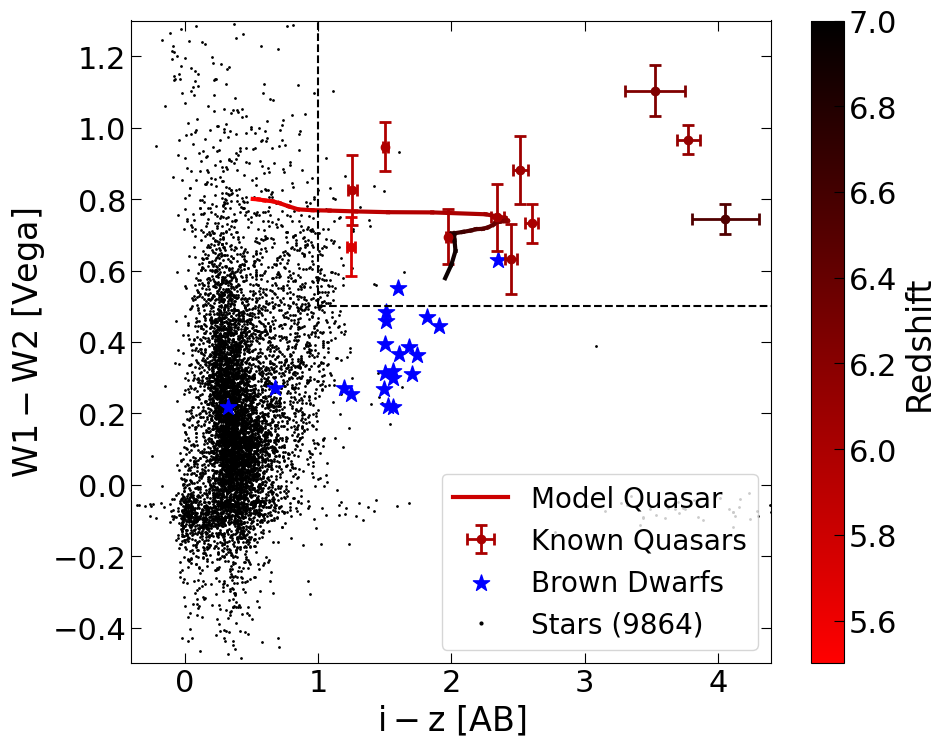

In [3]:
fg, ax = plt.subplots(figsize=(10,8))

# Plotting stars from DES tiles
star_sc = ax.scatter(
    tile_stars['i-z'], tile_stars['W1-W2'],
    c='k', s=1
)

# Plotting dwarfs
dwf_sc = ax.scatter(
    dwarfs_df['i-z'], dwarfs_df['W1-W2'],
    marker='*',c='b',s=150,
    label='Brown Dwarfs'
)

# Plotting known HZQs
def redshift_colour(z):
    "Colours a shade of red between z=5.5 and z=7.0"
    return np.array([1-(z-5.5)/1.5, 0,0,1])

for i, row in hzq_df.iterrows():
    col = redshift_colour(row['redshift'])
    hzq_eb = ax.errorbar(
        row['i-z'], row['W1-W2_vg'],
        xerr=row['i-z_err'], yerr=row['W1-W2_err'],
        fmt='o', mfc=col, mec=col, ms=6,
        elinewidth=2, ecolor=col, capsize=4, capthick=2,
        label='Known Quasars'
    )

# Adding QSO tracks
blur=15 # Samples every {blur} points
for ((i, row1), (j,row2)) in zip(
    qso_track[::blur][:-1].iterrows(),
    qso_track[::blur][1:].iterrows(),
):
    ax.plot(
        [row1['i-z'], row2['i-z']],
        [row1['W1-W2'], row2['W1-W2']],
        c=redshift_colour(row1['redshift']),
        lw=3
    )

# Colorbar
redshift_colors = np.zeros((256,4))
redshift_colors[:,3] = 1.
redshift_colors[:,0] = np.linspace(1.,0.,256)
redshift_cmap = colors.ListedColormap(redshift_colors)
cbar = fg.colorbar(
    cm.ScalarMappable(
        norm=colors.Normalize(vmin=5.5, vmax=7.),
        cmap=redshift_cmap
    ), ax=ax
)
cbar.ax.set_ylabel('Redshift')

# Selection lines
ax.vlines(1., .5, 1.3, colors='k', linestyles='dashed')
ax.hlines(.5, 1., 4.4, colors='k', linestyles='dashed')

ax.set_xlabel(r'$\mathrm{i}-\mathrm{z}$ [AB]')
ax.set_ylabel(r'$\mathrm{W1}-\mathrm{W2}$ [Vega]')
ax.set_xlim(-.4,4.4)
ax.set_ylim(-.5,1.3)
# Legend
legend_elements = [
    lines.Line2D([0],[0], c=[.8,0,0,1], lw=3, label='Model Quasar'),
    hzq_eb,
    dwf_sc,
    lines.Line2D([0],[0],c='k',lw=0,marker='o',ms=2, label=f'Stars ({len(tile_stars)})')
]
ax.legend(handles=legend_elements, loc='lower right')
fg.tight_layout()
fg.savefig('../figs/selection_criteria.eps', format='eps')

## Clustering Space

In [4]:
fl = np.load('../data/processed/embedding.npz')
ids = fl['ids'].astype(int)
embedding = fl['embedding']

fl = np.load('../data/processed/ids_images.npz')
imgs = fl['imgs']

hzq_df = pd.read_csv('../data/external/known_hzqs.csv')
is_hzq = np.array(
    [coi in hzq_df['COADD_OBJECT_ID'].values
    for coi in ids]
).astype(int)
hzq_arch = [1621863463, 1695974542] # Archival quasars
is_hzq[ids==hzq_arch[0]]=2
is_hzq[ids==hzq_arch[1]]=2

cut_df = pd.read_csv('../data/processed/cut_crossmatched_objects.csv', index_col=0)
cut_df = cut_df.loc[ids]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


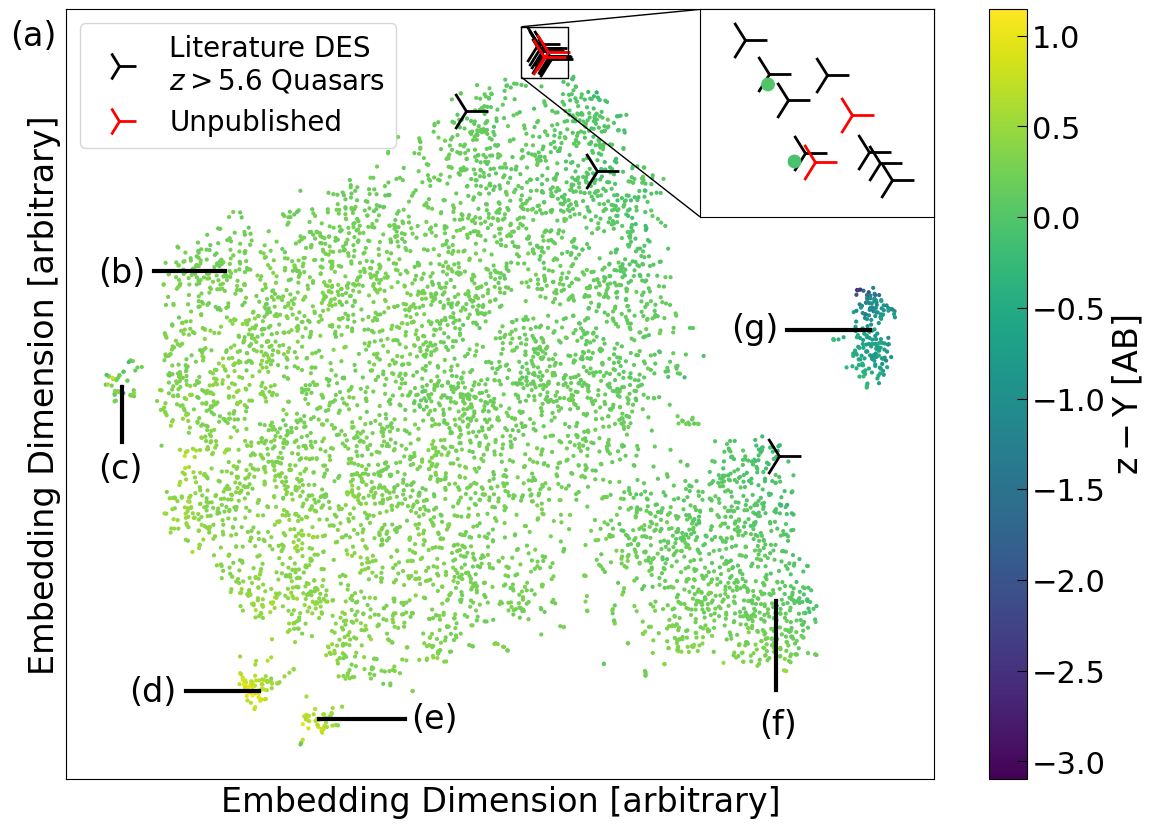

In [5]:
fg, ax = plt.subplots(figsize=(14,10))
qm='4'
cmp = cm.viridis

insax = ax.inset_axes([.73,.73,.27,.27])
ax.scatter(
    embedding[is_hzq==0,0], embedding[is_hzq==0,1],
    c=(cut_df['z_mag']-cut_df['Y_mag'])[is_hzq==0],
    cmap=cmp, s=4
)
for s, axis in zip([4,20],[ax, insax]):
    axis.scatter(
        embedding[is_hzq==1,0], embedding[is_hzq==1,1],
        s=1000, marker=qm, c='k', linewidths=2
    )
    axis.scatter(
        embedding[is_hzq==2,0], embedding[is_hzq==2,1],
        s=1000, marker=qm, c='r', linewidths=2
    )
    axis.set_xticks([])
    axis.set_yticks([])
sc = insax.scatter(
    embedding[is_hzq==0,0], embedding[is_hzq==0,1],
    c=(cut_df['z_mag']-cut_df['Y_mag'])[is_hzq==0],
    cmap=cmp, s=80
)

# Box
(x0,x1,y0,y1)=(7.5,15,45,52)
xlims=ax.get_xlim()
ylims=ax.get_ylim()
ax.plot([x0,x1,x1,x0,x0],[y1,y1,y0,y0,y1],'k',lw=1)
ax.plot([x0+.2,36],[y1,ylims[1]],'k',lw=1)
ax.plot([x0+.2,36],[y0,26],'k',lw=1)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# Colorbar
cbar = fg.colorbar(sc, ax=ax)
cbar.set_label(r'$\mathrm{z}-\mathrm{Y}$ [AB]')

ax.set_xlabel('Embedding Dimension [arbitrary]')
ax.set_ylabel('Embedding Dimension [arbitrary]')

insax.set_xlim(x0+2, x1-2)
insax.set_ylim(y0+2, y1-2)

# Legend
custom_lines = [
    lines.Line2D([0],[0], marker=qm,ms=24, color='k',lw=0,mew=2),
    lines.Line2D([0],[0], marker=qm,ms=24, color='r',lw=0,mew=2)
]
ax.legend(
    custom_lines,
    [r"""Literature DES
$z>5.6$ Quasars""",
    r'Unpublished'],
    loc='upper left'
)

for lbl, coi, text_coords, to_coords in zip(
    ['b','c','d','e','f','g'],
    [1358001747, 894712355, 1452522417, 1248581703, 904105229, 1097290985],
    [[-60,17], [-60,-10], [-55,-40.5],
     [-10,-44.2], [45.5,-45], [41,9.3]],
    [['x',-51], ['y',-5], ['x',-46],
     ['x',-11], ['y',-39], ['x',50]]
):
    ax.annotate(
        f'({lbl})',
        xy=text_coords
    )
    embed_point = embedding[ids==coi][0]
    if to_coords[0]=='x':
        to_point = [to_coords[1], embed_point[1]]
    else:
        to_point = [embed_point[0], to_coords[1]]
    ax.plot(
        [embed_point[0], to_point[0]],
        [embed_point[1], to_point[1]],
        c='k', lw=3
    )

ax.annotate('(a)', xy=[xlims[0]-9, ylims[1]-5],
annotation_clip=False)
fg.savefig('../figs/latent_space.eps', format='eps', bbox_inches='tight')

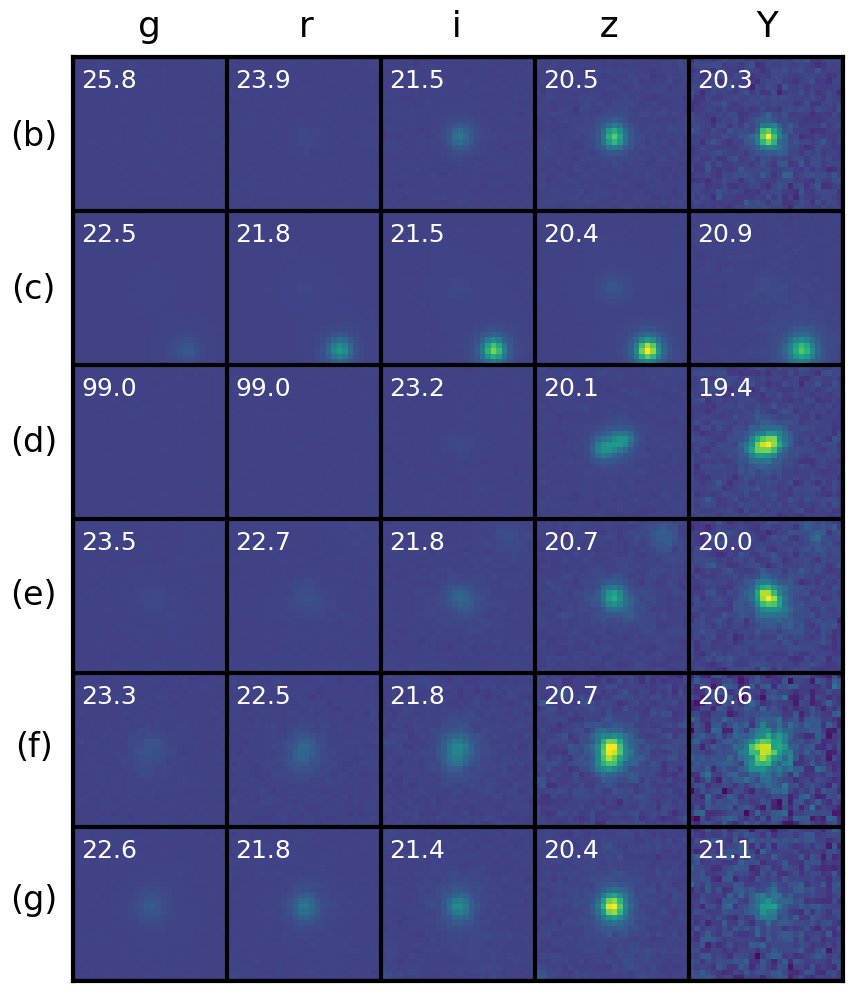

In [6]:
eg_cois = [1358001747, 894712355, 1452522417, 1248581703, 904105229, 1097290985]
conc_img = np.zeros((28*6, 28*5))
for i, eg_coi in enumerate(eg_cois):
    obj_img = imgs[ids==eg_coi][0]
    for j in range(5):
        conc_img[i*28:(i+1)*28, j*28:(j+1)*28] = obj_img[:,:,j]
# Normalising
conc_img /= np.max(conc_img) # All below 1
for i in range(6):
    conc_img[i*28:(i+1)*28,:] /= np.max(conc_img[i*28:(i+1)*28,:])

fg, ax = plt.subplots(figsize=(10,12))
ax.imshow(conc_img)
# Annotating mags
for i, eg_coi in enumerate(eg_cois):
    for j, band in enumerate(['g','r','i','z','Y']):
        ax.annotate(
            f'{cut_df.loc[eg_coi][f"{band}_mag"]:.1f}',
            xy=[j*28+1,i*28+5],
            c='white', fontsize=18
        )
spacer = '            '
ax.set_title(f'g{spacer}r{spacer}i{spacer}z{spacer}Y', pad=15)
spacer = '\n'*4
ax.set_ylabel(f"(b){spacer}(c){spacer}(d){spacer}(e){spacer}(f){spacer}(g)",
              rotation=0,
              y=.07, labelpad=25)
# Gridding
xtix = np.linspace(0,28*5, 6)-.5
ytix = np.linspace(0,28*6,7)-.5
ax.set_xticks(xtix)
ax.set_yticks(ytix)
ax.set_xticklabels([])
ax.set_yticklabels([])
lw=3
for spn in ['top','bottom','left','right']:
    ax.spines[spn].set_linewidth(lw)
ax.grid(visible=True, c='k', lw=lw)

fg.savefig('../figs/latent_examples.eps', format='eps', bbox_inches='tight')

In [7]:
def plot_simple_embedding(points):
    df = pd.DataFrame(index=ids.astype(int), columns=['x','y','url'])
    df['x'] = points[:,0]
    df['y'] = points[:,1]
    df['id'] = ids.astype(int)
    df['url'] = [f'https://xbyrne.github.io/images/grizY/{idd}.png' for idd in ids]
    img_tooltip = """@{id}
                        <img src="@{url}"
                            width="500"
                            height="auto"
                          </img>"""
                        #   style="width="100"; height="1";">
    P = bokeh.plotting.figure(tooltips=img_tooltip)
    P.circle('x', 'y', size=3, source=df)
    P.x('x', 'y',
        size=30,
        line_width=2,
        color='black',
        source=df.loc[hzq_df.COADD_OBJECT_ID])
    # P.min_border_left=200
    P.min_border_right=200
    # P.min_border_top=100
    P.min_border_bottom=200
    # P.axis.axis_line_width = 0
    # P.axis.major_tick_line_alpha = 0
    # P.axis.minor_tick_line_alpha = 0
    # P.axis.major_label_text_alpha=0

    bokeh.plotting.output_notebook()
    bokeh.plotting.show(P)
    return P
P = plot_simple_embedding(embedding)

Loading BokehJS ...

The below cell is code to find some data for a table in the paper, listing details of all the quasars selected by the neural network.

In [84]:
# from astropy.coordinates import SkyCoord
# from astropy import units as u
obj = cut_df.loc[1599741416]
coords = SkyCoord(obj.ra_des*u.deg, obj.dec_des*u.deg)
coords.ra.hms
# obj.filter(regex='.*mag').round(2)

hms_tuple(h=6.0, m=3.0, s=52.25568000000507)

## SED Fitting

In [71]:
# Images
fl = np.load('../data/processed/ids_images.npz')
ids = fl['ids'].astype(int)
imgs = fl['imgs']
# Magnitudes
cut_df = pd.read_csv('../data/processed/cut_crossmatched_objects.csv', index_col=0)
cut_df = cut_df.loc[ids]
band_offsets = {'g':0,'r':0,'i':0,'z':0,'Y':0,'J':0,'K':0,
'W1':2.699,'W2':3.339}
# LePHARE
fl = np.load('../data/sed_fitting/lephare_spectra_chi2s.npz')
ids_lephare = fl['ids']
wavs_lephare = fl['wavelengths']
lephare_spectra = fl['spectra']
# BAGPIPES
fl = np.load('../data/sed_fitting/bagpipes_ids_spectra.npz')
ids_bagpipes = fl['ids']
wavs_bagpipes = fl['wavelengths']
bagpipes_spectra = fl['spectra']
# Filters
bands = ['g','r','i','z','Y','J','K','W1','W2']
filters = []
for band, filename in zip(bands, os.listdir('../data/sed_fitting/filters')):
    filetext = np.loadtxt(f'../data/sed_fitting/filters/{filename}')
    wavelengths = filetext[:,0]*unit['AA']
    transmission = filetext[:,1]
    filters.append(Filter(
        wavelengths, transmission,
        name=band, dtype='photon', unit='Angstrom'
    ))
filters = sorted(filters, key=lambda fil:fil.leff.value)
eff_wavs = [filter.leff.value for filter in filters]
def bandpasses(wavelengths, fluxes):
    """Returns the fluxes through each band. `fluxes` in Jy."""
    wavelengths*=unit['AA']
    fluxes*=unit['Jy']
    return [filter.get_flux(wavelengths, fluxes) for filter in filters]
# My quasars and their names
lhzq_cois = [1143273115, 1599741416]
coord_name_dict = dict(zip(
    lhzq_cois, [r'J0109–5424', r'J0603–3923']
))
# Colour scheme + labels
lephare_colours = ['g','b','orange']
lephare_labels = ['Galaxy','Quasar','Star']
bagpipes_colours = ['g','b','m']
bagpipes_labels = ['Galaxy','Quasar','Lensed Quasar']
band_hues = cm.rainbow(
    colors.Normalize(
        vmin=min(eff_wavs),
        vmax=max(eff_wavs)
    )(eff_wavs)
)
band_shade = band_hues
band_shade[:,3] = .2
band_lines = band_hues
band_lines[:,3] = .4

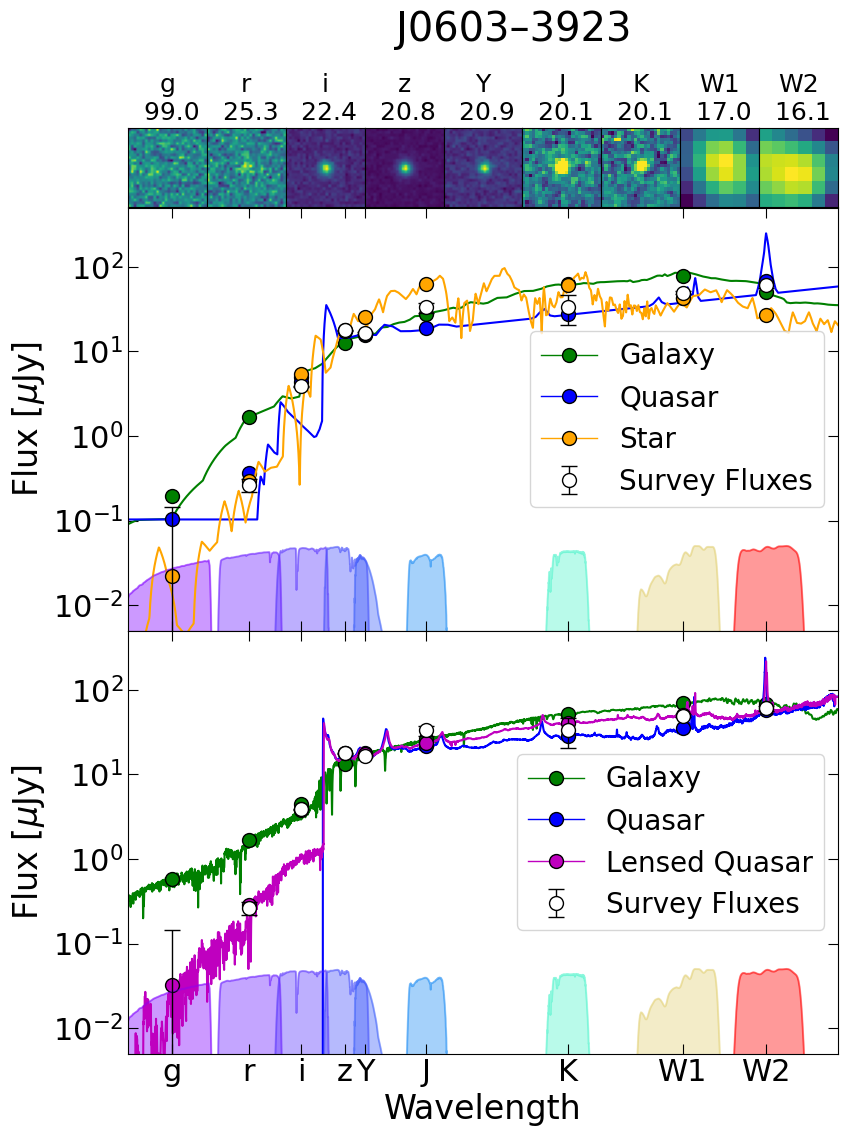

In [74]:
coi = lhzq_cois[1]
fg, axs = plt.subplot_mosaic(
    [
        bands,
        ['LePHARE']*9,
        ['BAGPIPES']*9
    ],
    figsize=(9,12),
    height_ratios=[.75,4,4],
    gridspec_kw={'hspace':0,'wspace':0}
)
# fg.subplots_adjust(hspace=0, wspace=0)
# Imaging
for i, band in enumerate(['g','r','i','z','Y']):
    axs[band].imshow(imgs[ids==coi][0][:,:,i])
for band in ['J','K']:
    axs[band].imshow(255-plt.imread(
        f'../figs/{coi}_{band}.jpg'
    ))
for band in ['W1','W2']:
    axs[band].imshow(
        fits.open(f'../figs/{coi}_{band}.fits')[0].data
    )
colour_row = cut_df.loc[coi]
for band in bands:
    ax = axs[band]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(
        f'{band}\n{colour_row[f"{band}_mag"] - band_offsets[band] : .1f}',
        fontsize=18
    )

ax = axs['LePHARE']
for i, (col, lbl) in enumerate(zip(lephare_colours, lephare_labels)):
    spectrum = lephare_spectra[ids_lephare==coi,i,:][0]
    ax.plot(
        wavs_lephare, spectrum, c=col
    )
    ax.plot(
        eff_wavs, bandpasses(wavs_lephare, spectrum),
        c=col, marker='o', mec='k', lw=0, ms=10,
        label='_nolegend_'
    )

ax = axs['BAGPIPES']
for i, (col, lbl) in enumerate(zip(bagpipes_colours, bagpipes_labels)):
    spectrum = bagpipes_spectra[ids_bagpipes==coi,i,:][0]
    ax.plot(
        wavs_bagpipes, spectrum, c=col
    )
    ax.plot(
        eff_wavs, bandpasses(wavs_bagpipes, spectrum),
        c=col, marker='o', mec='k', lw=0, ms=10,
        label='_nolegend_'
    )

factor=5e-2
ymax=100

for ax, cols, lbls in zip(
    [axs['LePHARE'], axs['BAGPIPES']],
    [lephare_colours, bagpipes_colours],
    [lephare_labels, bagpipes_labels]
):
    for filter, shade_col, line_col in zip(
        filters, band_shade, band_lines
    ):
        filter_wav = filter.wavelength.value
        filter_transm = filter.transmit*factor
        ax.fill_between(
            filter.wavelength.value,
            filter.transmit*factor,
            color=shade_col,
            label='_nolegend_'
        )
        ax.plot(
            filter_wav, filter_transm,
            c=line_col,
            label='_nolegend'
        )

    true_fluxes = ax.errorbar(
        eff_wavs, colour_row[[f'{band}_flux' for band in bands]],
        yerr = colour_row[[f'{band}_fluxerr' for band in bands]],
        marker='o', mfc='white', mec='k', ms=10, lw=0,
        ecolor='k', elinewidth=1, capsize=5.5,
        label='Survey Fluxes'
    )
    # Legend
    legend_elements = [
        lines.Line2D(
            [0],[0], color=cols[j], lw=1,
            marker='o', mfc=cols[j], mec='k', ms=10,
            label=lbls[j]
        ) for j in range(3)
    ]+[true_fluxes]
    ax.legend(handles = legend_elements, loc='center right')

    ax.set_xlim([4e3,6e4])
    ax.set_xscale('log')
    ax.set_xticks(eff_wavs, which='major')
    ax.set_xticklabels(bands)
    ax.tick_params(which='minor', length=0)
    ax.set_yscale('log')
    # ax.set_ylim([0,ymax])
    ax.set_ylim([5e-3,5e2])
    ax.set_ylabel(f'Flux [$\mu$Jy]')
    ax.set_xlabel('Wavelength')

fg.suptitle(coord_name_dict[coi], x=.6, y=.96)
fg.set_rasterized(True)
fg.tight_layout()
fg.savefig(f'../figs/{coord_name_dict[coi][:5]}_sed.eps', format='eps')

In [88]:
fl = np.load('../sed_fitting/bagpipes/mcmc_results.npz')
cois = fl['ids']
gq_samples = fl['samples_GQ']
gq_logprobs = fl['log_probs_GQ']

Text(0.5, 1.0, '$z=5.979\\pm0.002$')

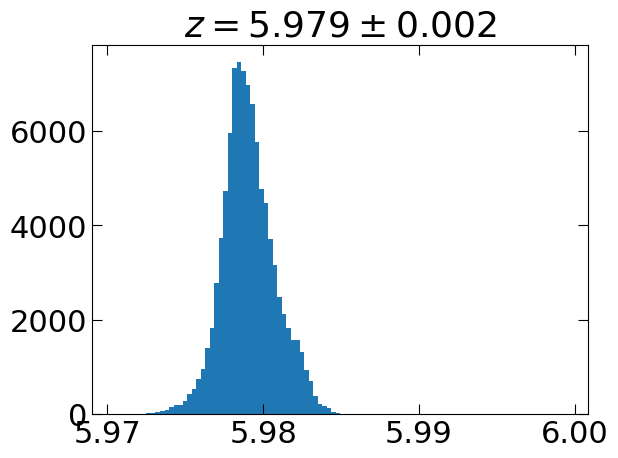

In [108]:
lhzq_cois = [1143273115, 1599741416]
coi = 1695974542#lhzq_cois[1]
redshift_samples = np.ravel(gq_samples[cois==coi,:,:,-1][0])
redshift_samples = redshift_samples[redshift_samples<6]
plt.hist(np.ravel(redshift_samples), bins=100);
plt.title(rf'$z={np.mean(redshift_samples):.3f}\pm{np.std(redshift_samples):.3f}$')